# Legal Case Document Summarization
### Using Advanced NLP Techniques for Extractive and Abstractive Summarization

This project leverages the BART model and HuggingFace Transformers to generate summaries for lengthy legal documents. The system aims to assist legal professionals in quickly reviewing key information from case documents.

Team Members:
1. Ankita Bondre
2. Yashawsi Patki
3. Tanay Gawade

### Import Libraries

In [ ]:
!pip install datasets

In [ ]:
!pip install gradio

Killing tunnel 127.0.0.1:7860 <> https://cfd39001dbdda67b9f.gradio.live


In [2]:
# Import necessary libraries
import os
import pandas as pd
import torch
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments, DataCollatorForSeq2Seq
from datasets import Dataset
import gradio as gr

### Dataset Preparation

In [3]:
import gdown
import zipfile
import os

def download_and_unzip(drive_url, output_dir):
    """
    Downloads a file from a Google Drive link and unzips it.

    Parameters:
        drive_url (str): The shareable Google Drive link.
        output_dir (str): Directory where the contents will be extracted.
    """
    # Extract the file ID from the Google Drive URL
    file_id = drive_url.split('/d/')[1].split('/view')[0]
    download_url = f"https://drive.google.com/uc?id={file_id}"

    # Define the local file path
    zip_path = os.path.join(output_dir, "dataset.zip")

    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Download the file
    print("Downloading the dataset...")
    gdown.download(download_url, zip_path, quiet=False)

    # Unzip the file
    print("Unzipping the dataset...")
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(output_dir)
        print(f"Dataset unzipped successfully to '{output_dir}'.")
    except zipfile.BadZipFile:
        print("Error: The downloaded file is not a valid .zip file.")

    # Optionally, delete the zip file after extraction
    os.remove(zip_path)
    print("Temporary .zip file removed.")

# Example usage
drive_url = "https://drive.google.com/file/d/15DZmCc2Y3lycUPUv9eqGysOnwF8ClHvs/view?usp=share_link"
output_dir = "path/to/extracted_folder"  # Replace with the desired output directory

download_and_unzip(drive_url, output_dir)


Downloading...
From (original): https://drive.google.com/uc?id=15DZmCc2Y3lycUPUv9eqGysOnwF8ClHvs
From (redirected): https://drive.google.com/uc?id=15DZmCc2Y3lycUPUv9eqGysOnwF8ClHvs&confirm=t&uuid=f929c6ab-3763-4a9d-91d0-cd03027c80f1
To: /content/path/to/extracted_folder/dataset.zip
100%|██████████| 97.8M/97.8M [00:01<00:00, 97.0MB/s]


Unzipping the dataset...
Dataset unzipped successfully to 'path/to/extracted_folder'.
Temporary .zip file removed.


In [4]:
# Function to load data from judgment and summary folders
def prepare_data(judgement_folder, summary_folder, limit=None):
    judgments, summaries = [], []
    judgement_files = sorted(os.listdir(judgement_folder))[:limit]
    summary_files = sorted(os.listdir(summary_folder))[:limit]

    for j_file, s_file in zip(judgement_files, summary_files):
        with open(os.path.join(judgement_folder, j_file), "r", encoding="utf-8") as f:
            judgments.append(f.read().strip())
        with open(os.path.join(summary_folder, s_file), "r", encoding="utf-8") as f:
            summaries.append(f.read().strip())

    return pd.DataFrame({"input_ids": judgments, "labels": summaries})

# Display sample data
data = prepare_data('/content/dataset/IN-Abs/train-data/judgement', '/content/dataset/IN-Abs/train-data/summary', limit=5)
data.head()

,input_ids,labels
0,Appeal No. LXVI of 1949.\nAppeal from the High...,The charge created in respect of municipal pro...
1,Civil Appeal No.94 of 1949.\n107 834 Appeal fr...,"An agreement for a lease, which a lease is by ..."
2,"iminal Appeal No. 40 of 1951, 127 Appeal from ...","The question whether a Magistrate is ""personal..."
3,Appeal No. 388 of 1960.\nAppeal by special lea...,The appellant was a member of a joint Hindu fa...
4,Appeal No. 198 of 1954.\nAppeal from the judgm...,The appellant was the Ruler of the State of Ba...


In [5]:
# Function to load data from judgment and summary folders
def prepare_data(judgement_folder, summary_folder, limit=None):
    judgments, summaries = [], []
    judgement_files = sorted(os.listdir(judgement_folder))[:limit]
    summary_files = sorted(os.listdir(summary_folder))[:limit]

    for j_file, s_file in zip(judgement_files, summary_files):
        with open(os.path.join(judgement_folder, j_file), "r", encoding="utf-8") as f:
            judgments.append(f.read().strip())
        with open(os.path.join(summary_folder, s_file), "r", encoding="utf-8") as f:
            summaries.append(f.read().strip())

    return pd.DataFrame({"input_ids": judgments, "labels": summaries})

### Tokenization

In [6]:
# Load HuggingFace tokenizer and model for fine-tuning
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
# Tokenize data for training
def tokenize_function(batch):
    inputs = tokenizer(batch["input_ids"], max_length=1024, truncation=True, padding="max_length")
    targets = tokenizer(batch["labels"], max_length=128, truncation=True, padding="max_length")
    inputs["labels"] = targets["input_ids"]
    return inputs

In [8]:
# Load and tokenize dataset
def load_and_tokenize_dataset(train_judgement_folder, train_summary_folder, eval_judgement_folder, eval_summary_folder, limit=None):
    print("Loading training dataset...")
    train_data = prepare_data(train_judgement_folder, train_summary_folder, limit)
    print("Loading evaluation dataset...")
    eval_data = prepare_data(eval_judgement_folder, eval_summary_folder, limit)

    train_dataset = Dataset.from_pandas(train_data).map(tokenize_function, batched=True, remove_columns=["input_ids", "labels"])
    eval_dataset = Dataset.from_pandas(eval_data).map(tokenize_function, batched=True, remove_columns=["input_ids", "labels"])
    return train_dataset, eval_dataset

### Model Fine-Tuning

In [9]:
def fine_tune_model(train_judgement_folder, train_summary_folder, eval_judgement_folder, eval_summary_folder, output_dir, limit=None):
    print("Loading and preparing datasets...")
    train_dataset, eval_dataset = load_and_tokenize_dataset(train_judgement_folder, train_summary_folder, eval_judgement_folder, eval_summary_folder, limit)

    data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="steps",
        save_strategy="steps",
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        logging_dir="./logs",
        logging_steps=100,
        save_steps=500,
        num_train_epochs=3,
        weight_decay=0.01,
        eval_steps=200,
        remove_unused_columns=False,
    )
    print("Starting fine-tuning...")
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=data_collator,
    )
    trainer.train()
    print("Fine-tuning complete. Saving model...")
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    print(f"Model saved at {output_dir}")

In [12]:
fine_tune_model(
      "/content/path/to/extracted_folder/dataset/IN-Abs/train-data/judgement",
      "/content/path/to/extracted_folder/dataset/IN-Abs/train-data/summary",
      "/content/path/to/extracted_folder/dataset/IN-Abs/test-data/judgement",
      "/content/path/to/extracted_folder/dataset/IN-Abs/test-data/summary",
      "/content/drive/MyDrive/output/legal-bart",
      limit=2000
    )

Loading and preparing datasets...
Loading training dataset...
Loading evaluation dataset...


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting fine-tuning...


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ypatki (ypatki-yeshiva-university). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss
200,0.909000,2.261642
400,0.957800,2.366834
600,0.959800,2.285464
800,0.909200,2.307889
1000,0.892200,2.242146
1200,0.596100,2.542474
1400,0.547700,2.537194
1600,0.587700,2.591123
1800,0.593300,2.515821
2000,0.641500,2.489626


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Fine-tuning complete. Saving model...
Model saved at /content/drive/MyDrive/output/legal-bart


### Abstractive Summarization

In [15]:
import math
# Load fine-tuned model and tokenizer
model_path = "/content/drive/MyDrive/output/legal-bart"  # Update this if needed
tokenizer = BartTokenizer.from_pretrained(model_path)
model = BartForConditionalGeneration.from_pretrained(model_path)

# Function to split text into chunks
def split_into_chunks(text, max_length):
    """
    Splits a long text into smaller chunks that fit within the model's max_length.

    Args:
        text (str): The input text.
        max_length (int): Maximum token length for the model.

    Returns:
        list: List of text chunks.
    """
    tokens = tokenizer.tokenize(text)
    num_chunks = math.ceil(len(tokens) / max_length)
    chunks = []

    for i in range(num_chunks):
        start_idx = i * max_length
        end_idx = (i + 1) * max_length
        chunk_tokens = tokens[start_idx:end_idx]
        chunks.append(tokenizer.convert_tokens_to_string(chunk_tokens))

    return chunks

# Function to summarize text
def summarize_large_text(text, chunk_size=1024, max_summary_length=128, min_summary_length=30):
    """
    Summarizes a large text by splitting it into chunks and summarizing each chunk.

    Args:
        text (str): The input text.
        chunk_size (int): Maximum token length for each chunk.
        max_summary_length (int): Maximum length of the generated summary.
        min_summary_length (int): Minimum length of the generated summary.

    Returns:
        str: Combined summary for all chunks.
    """
    chunks = split_into_chunks(text, chunk_size)
    combined_summary = ""

    print(f"Number of chunks: {len(chunks)}")
    for i, chunk in enumerate(chunks):
        print(f"Summarizing chunk {i + 1}/{len(chunks)}...")
        inputs = tokenizer(chunk, return_tensors="pt", max_length=chunk_size, truncation=True)
        summary_ids = model.generate(
            inputs["input_ids"],
            max_length=max_summary_length,
            min_length=min_summary_length,
            num_beams=4,
            length_penalty=2.0,
            no_repeat_ngram_size=3,
            early_stopping=True,
        )
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        combined_summary += summary + " "  # Combine summaries with a space

    return combined_summary.strip()

# Example input (use your long text here)
text = ''''N: Criminal Appeal No. 8 of 1951.
Appeal from an Order of the High Court of Bombay (Bavdekar and Chainani JJ.) dated 20th February, 1950, in Criminal Appeal No. 106 of 1950 arising out of an order dated 9th January, 1950, of the Presidency Magistrate, 19th Court, Esplanade, Bombay, in Case No. 10879/P of 1949.
The facts are stated in the judgment.
Iswarlal C. Dalai and R.B. Dalai, for the appellant.
C.K. Daphtary, Solicitor General for India (G. N. Joshi, with him) for the Republic of India (respondent No. 1).Jindra Lal for the respondent No. 2. 1952.
February 1.
The Judgment of the Court was deliv ered by CHANDRASEKHARA AIYAR J.
The facts out of which this Crimi nal Appeal has arisen are not long.
The appellant, W.H. King, who is carrying on a business in Bombay under the name and style of Associated Commercial Enterprises, was the tenant of a flat on the second floor of a building called "Ganga Vihar", Marine Drive, Bombay, which belongs to a lady named Durgeshwari Devi.
The tenancy was a monthly one, the rent being Rs. 215.
It is said that the appellant wanted to go to the United Kingdom for treatment of his failing eye sight and he got into touch with the complainant Mulchand Kodumal Bhatia, who is the second respondent in this appeal, through one Sayed for the purpose of making necessary ar rangements about the flat occupied by him in view of his intended departure.
The prosecution case is that the accused demanded a sum of Rs. 30,000 which was later on reduced to Rs. 29,500 as consideration for putting the complainant in vacant possession of the flat and an additional amount of Rs. 2,000 for the furniture, and that the complainant agreed to pay these sums.
The complainant actually paid the accused two sums of 420 Rs. 500 each on 7th November, 1948, and 17th November, 1948.
He, however, got into touch with the police on 1 12 1948, and in conjunction with the latter, a trap was laid for the appellant.
It was arranged that the complainant should bring with him Rs. 1,000, being the balance due in respect of the furniture and that the police would give him Rs. 29,500 to be paid to the appellant.
The complainant and a Sub Inspec tor, posing as the complainant 's brother, went to the appel lant on 4 12 1948, and paid him the two sums of money; and the keys of the flat and the motor garage were handed over to the complainant.
As the appellant and his wife were leaving the flat, the man, who masqueraded as the complain ant 's brother, threw off his disguise and disclosed his identity.
The police party, who were down below ready for the raid, held up the car of the appellant and recovered the sum of Rs. 30,500 from the rear seat of the car and also some papers, a typed draft of a partnership agreement be tween the complainant and the appellant and an application form for permission to occupy the building as caretaker.
From the complainant were recovered the bunch of keys and the documents that were handed over to him by the appellant, namely, the letter handing vacant possession (Exhibit D).
the receipt for Rs. 2,000 for the articles of furniture (Exhibit E), a letter to the Bombay Gas Company for transfer of the gas connection to the name of the complainant (Exhib it F), and the letter to the Bombay Electric Supply and Transport Committee for transfer of the telephone connec tions and the deposit of Rs. 27 (Exhibit G).
The appellant was charged under section 18(1) of the Bombay Rents, Hotel and Lodging House Rates Control Act, LVII of 1947, for receiving a pugree of Rs. 29,500 and he was further charged under section 19(2) of the said Act for receiving the said sum as a condition for the relin quishment of his tenancy.
His wife, who was the second accused in the case, was charged with aiding and abetting her husband in the commission of the two offences.
421 The defence of the appellant was that he was in search of a partner to carry on his business during his intended absence, who was also to act as caretaker of his flat anal that it was in this connection and with this object in view that he entered into negotiations with the complain ant.
The sum of Rs. 29 500 was not pugree but represented capital for 0 12 0 share in the business and as the com plainant was also to be a caretaker of the flat, the sum of Rs. 2,000 was paid and received as a guarantee against disposal and damage of the furniture and it was agreed to be paid back on the appellant 's return to India.
The wife of the appellant denied any aiding and abetting.
The Presidency Magistrate, who tried the case, disbe lieved the defence on the facts, holding that what was received by the accused was by way of pugree.
As section 18 (1) of the Act was not applicable he convicted him under section 19(2) of the Act and sentenced him, in view of his old age and blindness, to one day 's simple imprisonment and a fine of Rs. 30,000.
The wife was acquitted, the evidence being insufficient to prove any abetment.
The appellant preferred an appeal to the High Court of Bombay but it was summarily dismissed on 20 2 1950.
He asked for a certificate under article 134(1)(c) of the Constitution but this was rejected on 10 4 1950.
Thereaf ter he applied for special leave to appeal to this Court and it was granted on 3 10 1950.
A short legal argument was advanced on behalf of the appellant based on the language of section 19 (1) of the Act and this is the only point which requires our consideration.
The section which consists of two parts is in these terms:" "(1) It shall not be lawful for the tenant or any person acting or purporting to act on behalf of the tenant to claim or receive any sum or any consideration as a condi tion for the relinquishment of his tenancy of any premises; 422 (2) Any tenant or person who in contravention of the provisions of sub section (1) receives any sum or considera tion shall, on conviction, be punished with imprisonment for a term which may extend to 6 months and shall also be pun ished with fine which shall not be less than the sum or the value of the consideration received by him.
" It was urged that the offence arises only on receipt of any sum or any consideration as a condition of the relin quishment by a tenant of his tenancy and that in the present case there was no such relinquishment.
Exhibit D, which is the most material document, under which the appellant handed over vacant possession of the flat to the complainant, constitutes or evidences an assignment of the tenancy and not a relinquishment.
It says : "I, W.H. King, hereby hand over vacant possession of my flat No. 3 situated on 2nd floor and garage No. 4 on the ground floor of Ganga Vihar Building on Plot No. 55 situated on Marine Drive Road to Mr. Mulchand Kodumal Bhatia from this day onward and that I have no claim whatsoever over this flat and Mr. Mulchand Kodumal Bhatia will pay the rent directly to the landlord.
" The argument raised on behalf of the appellant appears to us to be sound and has to be accepted.
The learned Solic itor General urged that 'the word "relinquishment" was not a term of art and was used in the section not in any strict technical sense but in its comprehensive meaning as giving up of possession of the premises; and he pointed out that if it was intended by the legislature that "relinquish ment" should have the limited meaning sought to be placed upon it on behalf of the appellant, the word "surrender" used in the Transfer of Property Act would have been more appropriate.
Sections 15 and 18 of the Act were referred to in this connection but in our opinion they lend no assist ance to the argument of the learned counsel.
Any sublet ting, assignment or transfer in any other manner of his interest by the tenant is made unlawful under 423 section 15.
Section 18 deals with the grant, renewal or continuance of a lease of any premises or the giving of his consent by the landlord to the transfer of a lease by sub lease or otherwise, and it provides that the landlord, who receives any fine, premium, or other like sum or deposit, or any consideration for the grant, renewal or continuance or the accord of consent oh would be guilty of an offence and liable to the punishment therein specified.
It would thus be seen that an assignment of the lease or transfer in any other manner by a tenant is not made an offence; the statute merely says that it is not a lawful transaction.
It is the landlord 's consent to the transfer of a lease by sub lease or otherwise on receipt of consideration that has been made an offence.
Then follows section 19 which speaks of the relinquishment of his tenancy of any premises by a tenant.
If, by the expression, an assignment such as we have in the present case was meant, appropriate words could have been used, such as the transfer by a tenant of his interest, which we find in section 108, sub clause (i), of the Trans fer of Property Act.
The distinction between an assignment on the one hand and relinquishment or surrender on the other is too plain to be ignored.
In the case of an assignment, the assignor contin ues to be liable to the landlord for the performance of his obligations under the tenancy and this liability is contrac tual, while the assignee becomes liable by reason of privity of estate.
The consent of the landlord to an assignment is not necessary, in the absence of a contract or local usage to the contrary.
But in the case of relinquishment, it cannot be a unilateral transaction; it can only be in favour of the lessor by mutual agreement between them.
The relin quishment of possession must be to the lessor or one who holds his interest.
In fact, a surrender or relinquishment terminates the lessee 's rights and lets in the lessor.
It is no doubt true that the word "relinquishment" does not occur in the Transfer of Property Act but it is found in many of the Tenancy Acts in various provinces where there are Sec tions which deal with the 55 424 relinquishment of their holdings by tenants in favour of the landlord by notice given to him in writing.
The section in question, it should be further noted, does not speak of relinquishment or giving up of possession,in general terms.
The words are "the relinquishment of his tenancy of any premises".
The relinquishment of a tenancy is equivalent to surrender by the lessee or tenant of his rights as such.
Whether abandonment of a tenancy would come within the meaning of relinquishment is a question that does not arise in this appeal, because in the face of Exhibit D, there is no abandonment in the sense that the tenant disappeared from the scene altogether saying nothing and making no arrange ments about his interest and possession under the lease.
As the statute creates an offence and imposes a penalty of fine and imprisonment, the words of the section must be strictly construed in favour of the subject.
We are not concerned so much with what might possibly have been intend ed as with what has been actually said in and by the language employed.
As in our view, there has been no "relinquishment" within the meaning of section 19, sub clause (1), the conviction under sub clause (2) cannot be sustained.
It is set aside and the fine of Rs. 30,000 will be refunded if it has al ready been paid.
The other parts of the order of the learned Presidency Magistrate, as regards the disposal of Rs. 1,000 paid by the complainant to the appellant and the sum of Rs. 29,500 brought in by the police, will, however, stand.
Conviction sit aside.
Agent for respondent No. 1: P.A. Mehta.
Agent for respondent No. 2: Ganpat Rai.
'''

# Summarize the text
final_summary = summarize_large_text(text)
print("Generated Summary:")
print(final_summary)

/usr/local/lib/python3.10/dist-packages/transformers/models/bart/configuration_bart.py:176: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(


Number of chunks: 3
Summarizing chunk 1/3...
Summarizing chunk 2/3...
Summarizing chunk 3/3...
Generated Summary:
The appellant was the tenant of a flat in Bombay on a monthly basis.
He wanted to go to the United Kingdom for treatment of his failing eye sight and got into touch with the second respondent through one Sayed for the purpose of making necessary ar rangements about the flat in view of his intended departure.
The police, in conjunction with the latter, laid a trap for the appellant.
It was arranged that the complainant should bring with him Rs. 1,000, being the balance due in respect of the furniture and that the police would give him the sum of Rs. 29,500 to be paid to the Section 18(1) of the , provides that the landlord, who receives any sum or consideration as a condition of the relinquishment by a tenant of his tenancy shall, on conviction, be punished with imprisonment for a term which may extend to six months and shall also be pun ished with fine which shall not be le

#### **Conclusion**

The generated summary effectively condenses the legal text, capturing key details about the appellant's tenancy and the legal provisions under **Sections 18(1)** and **19(2)** of the Tenancy Act. It highlights the court's distinction between "relinquishment" and "assignment" of tenancy, pivotal to overturning the conviction. The court ruled there was no relinquishment as defined by the statute, leading to the reversal of the fine imposed. The summary also emphasizes the judicial rationale for strict statutory interpretation. Future improvements could simplify legal jargon and enhance clarity. Overall, the summary provides a concise and accurate representation of the case.

###  Interactive Gradio Demo

In [16]:
# Gradio interface function
def gradio_demo(file):
    try:
        # Open and read the uploaded file
        with open(file.name, "r", encoding="utf-8") as f:
            text = f.read()
        print("Processing uploaded file...")

        # Generate summary
        summarized_text = summarize_large_text(text)
        print("Summarization complete.")
        return summarized_text
    except Exception as e:
        print(f"An error occurred: {e}")
        return f"Error: {e}"

# Gradio app
demo = gr.Interface(
    fn=gradio_demo,
    inputs=gr.File(label="Upload Legal Document (Text File)"),
    outputs=gr.Textbox(label="Generated Summary"),
    title="Legal Case Document Summarizer",
    description="Upload a legal document to generate abstractive summaries using a fine-tuned BART model. Handles large documents via chunking.",
)

if __name__ == "__main__":
    demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7b285e137419f5695f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### Screenshot of sample generated summary on Gradio
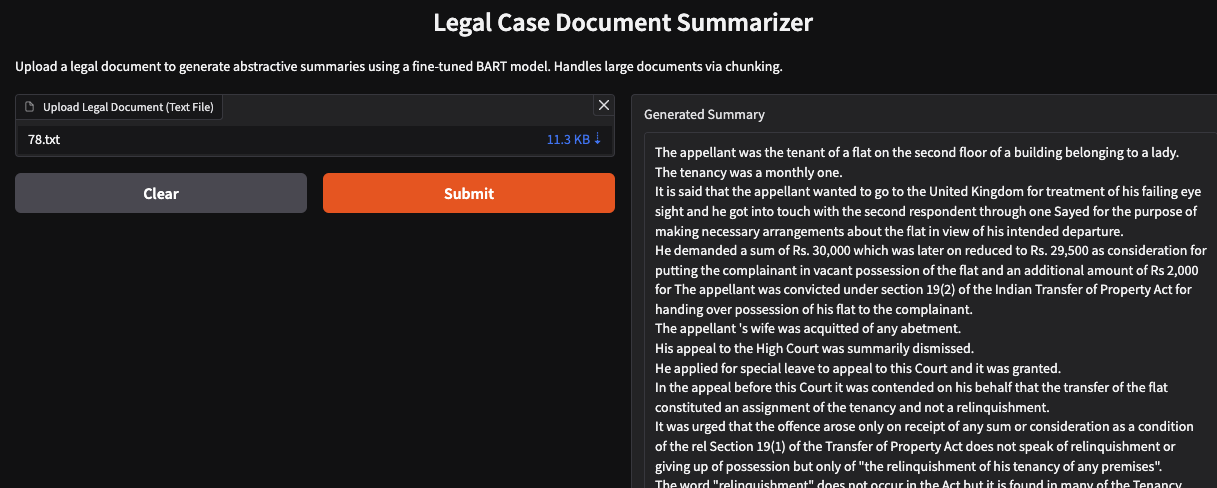
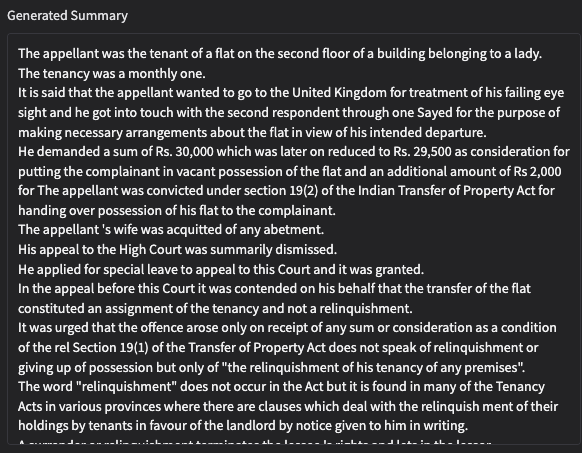

###  Results and Evaluation

In [8]:
import os
from bert_score import score
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# Paths to the directories
original_dir = "test-data/summary"  # Directory for original summaries
generated_dir = ""  # Directory for generated summaries

# List of IDs for summaries
file_ids = ["1778", "4451", "715", "78", "380"]

# Metrics Initialization
bert_scores = {"precision": [], "recall": [], "f1": []}
cosine_similarities = []

# Initialize Sentence-BERT model for semantic similarity
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Loop through each file ID
for file_id in file_ids:
    # Construct file paths
    original_path = os.path.join(original_dir, f"{file_id}.txt")
    generated_path = os.path.join(generated_dir, f"{file_id}.txt")
    
    # Check if both files exist
    if not os.path.exists(original_path):
        print(f"Original file not found: {original_path}")
        continue
    if not os.path.exists(generated_path):
        print(f"Generated file not found: {generated_path}")
        continue
    
    # Load content
    with open(original_path, "r", encoding="utf-8") as f:
        original_text = f.read().strip()
    with open(generated_path, "r", encoding="utf-8") as f:
        generated_text = f.read().strip()
    
    # BERTScore
    P, R, F1 = score([generated_text], [original_text], lang="en", model_type="bert-base-uncased")
    bert_scores["precision"].append(P.mean().item())
    bert_scores["recall"].append(R.mean().item())
    bert_scores["f1"].append(F1.mean().item())
    
    # Semantic Similarity (Cosine)
    original_embedding = sbert_model.encode([original_text])
    generated_embedding = sbert_model.encode([generated_text])
    cosine_sim = cosine_similarity(original_embedding, generated_embedding)[0][0]
    cosine_similarities.append(cosine_sim)

# Calculate Average Scores
average_bert_precision = sum(bert_scores["precision"]) / len(bert_scores["precision"]) if bert_scores["precision"] else 0
average_bert_recall = sum(bert_scores["recall"]) / len(bert_scores["recall"]) if bert_scores["recall"] else 0
average_bert_f1 = sum(bert_scores["f1"]) / len(bert_scores["f1"]) if bert_scores["f1"] else 0
average_cosine_similarity = sum(cosine_similarities) / len(cosine_similarities) if cosine_similarities else 0

# Print Results
print("Evaluation Metrics:")
print(f"BERTScore - Precision: {average_bert_precision:.4f}, Recall: {average_bert_recall:.4f}, F1: {average_bert_f1:.4f}")
print(f"Average Semantic Similarity (Cosine): {average_cosine_similarity:.4f}")

Evaluation Metrics:
BERTScore - Precision: 0.6893, Recall: 0.6585, F1: 0.6732
Average Semantic Similarity (Cosine): 0.6913


### **Conclusion**

The evaluation metrics reveal the following insights into the quality of the generated summaries:

#### **1. BERTScore Metrics**
- **Precision (`0.6893`)**: Approximately 69% of the semantic content in the generated summaries aligns with the reference summaries. This suggests the generated summaries are moderately accurate in capturing the key ideas from the references.
- **Recall (`0.6585`)**: About 66% of the semantic content in the reference summaries is successfully captured in the generated summaries, indicating room for improvement in fully reflecting the detailed meaning of the reference texts.
- **F1 Score (`0.6732`)**: Balancing precision and recall, the F1 score demonstrates moderate semantic similarity between the generated and reference summaries.

#### **2. Semantic Similarity (Cosine)**
- **Average Semantic Similarity (`0.6913`)**: Shows that the generated summaries are semantically close to the reference summaries. A score nearing 0.7 indicates the model effectively captures the overall meaning, but there is potential for further improvement.

#### **Key Takeaways**
- The generated summaries align reasonably well with the reference summaries in terms of semantic meaning but lack complete precision and recall.
- While the generated summaries capture most of the main ideas, they may omit some fine-grained details or include extraneous information.

#### **Final Thought**
The results highlight a moderate alignment between the generated and reference summaries. 

### Future Scope and Conclusion
#### Future Enhancements
- Integrate multilingual summarization.
- Deploy as a web application.
- Validate with legal experts.

## Conclusion
This project demonstrates the potential of NLP techniques in revolutionizing legal research by reducing document review time and effort.